In [15]:
import os
import pandas as pd
from colorama import Fore, Style  # Import colorama modules for text coloring
import shutil  # Import shutil for file operations
import numpy as np
import cv2 
import torch
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [14]:
# set the directory for the actual directory of the script
current_directory = r'C:\Users\matej.macek\OneDrive - Thermo Fisher Scientific\Desktop\Odevzdani\DeeplabV3-based method'
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))

In [16]:
from dataclasses import dataclass

@dataclass
class ProcessedData:
    ImageName: str
    BottomHeightY: int
    TopHeightY: int
    ContaminationHeight: int

In [18]:
nanoscale_mode = False
DEBUG = False
def test_csv_data(processed_data):
    if nanoscale_mode:
        csv_file = os.path.join(parent_directory, "contamination_measurements_before_resized.csv")
    else:
        csv_file = os.path.join(parent_directory, "contamination_measurements.csv")

    data = pd.read_csv(csv_file)
    succesed = 0
    failed = 0
    Zero_Contamination_Badly_Measured = 0
    # for error measurement
    errorDict = {'height': [], 'top': [], 'bottom': []}
    BaddlyValuatedNonContaminated = {'height': []}
    # Loop through processed data and compare with CSV
    for processed_item in processed_data:
        if processed_item is None:
            continue
        image_name = processed_item.ImageName
        
        if nanoscale_mode:
            # remove any type of extension
            image_name = os.path.splitext(image_name)[0]
        else:
        # change the image end from .png to .jpg
            image_name = image_name.replace(".jpg",".png")

        csv_row = data[data['ImageName'] == image_name]

        if not csv_row.empty:
            csv_values = csv_row.iloc[0]

            bottom_height_diff = abs(processed_item.BottomHeightY - csv_values['BottomHeightY'])
            top_height_diff = abs(processed_item.TopHeightY - csv_values['TopHeightY'])
            if processed_item.ContaminationHeight < 0:
                contamination_height_diff = abs(csv_values['ContaminationHeight'] + processed_item.ContaminationHeight)
            else:
                contamination_height_diff = abs(processed_item.ContaminationHeight - csv_values['ContaminationHeight'])

            similarity_threshold = 25  # Threshold for similarity between processed and CSV values
            
            if (
                bottom_height_diff <= similarity_threshold
                and top_height_diff <= similarity_threshold and 
                contamination_height_diff <= similarity_threshold
            ):
                # calculate the ERROR 
                succesed += 1
                # FILL DICTIONARY ERROR MEASUREMENT ----------------------------------
                if processed_item.ContaminationHeight == 0:
                    continue
                
                if nanoscale_mode:
                    # load csv file 
                    csv_file1 = os.path.join(current_directory, "pixelWidth.csv")
                    data1 = pd.read_csv(csv_file1)
                    csv_row1 = data1[data1['Filename'] == image_name]
                    if not csv_row1.empty:
                        pixel_width = csv_row1.iloc[0]['PixelWidth']
                        # convert from meters to nanometers
                        pixel_width = pixel_width * 1e9
                    else:
                        print ("Error: No pixel width found for the image: ", image_name)
                        succesed -= 1
                        continue

                    print ("Pixel width: ", pixel_width)
                    # calculate the error
                    bottom_height_diff = bottom_height_diff * pixel_width 
                    top_height_diff = top_height_diff * pixel_width
                    contamination_height_diff = contamination_height_diff * pixel_width

                errorDict['height'].append(contamination_height_diff)
                errorDict['top'].append(top_height_diff)
                errorDict['bottom'].append(bottom_height_diff)
                # END OF FILLING DICT ERROR MEASUREMENT ---------------------------
                if DEBUG:
                    print(Fore.GREEN + f"Values for {image_name} are close to the CSV values." + Style.RESET_ALL)
            else:
                if csv_values['ContaminationHeight'] == 0 or processed_item.ContaminationHeight == 0:
                    BaddlyValuatedNonContaminated['height'].append(processed_item.ContaminationHeight)
                    Zero_Contamination_Badly_Measured += 1
                    continue
                else:
                    failed += 1
                if DEBUG:
                    print (f"BottomHeightY: {processed_item.BottomHeightY} vs {csv_values['BottomHeightY']}")
                    print (f"TopHeightY: {processed_item.TopHeightY} vs {csv_values['TopHeightY']}")
                    print (f"ContaminationHeight: {processed_item.ContaminationHeight} vs {csv_values['ContaminationHeight']}")
                    print (f"BottomHeightY diff: {bottom_height_diff}")
                    print (f"TopHeightY diff: {top_height_diff}")
                    print (f"ContaminationHeight diff: {contamination_height_diff}")
                    print(Fore.RED + f"Values for {image_name} are not close to the CSV values. Image copied to failed images folder." + Style.RESET_ALL)
        else:
            print(f"No data found in CSV for {image_name}")

    print(f"Test results: {succesed} succesed, {failed} failed, {Zero_Contamination_Badly_Measured} zero contamination badly measured.")

    def plot_error_metrics(errorDict):
        # Extract the error metrics
        mae = {key: np.mean(values) for key, values in errorDict.items()}
        mse = {key: np.mean([v**2 for v in values]) for key, values in errorDict.items()}
        rmse = {key: np.sqrt(np.mean([v**2 for v in values])) for key, values in errorDict.items()}

        # Prepare data for plotting
        labels = list(mae.keys())
        mae_values = list(mae.values())
        mse_values = list(mse.values())
        rmse_values = list(rmse.values())
        
        x = np.arange(len(labels))  # the label locations
        width = 0.25  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, mae_values, width, label='MAE')
        rects2 = ax.bar(x, mse_values, width, label='MSE')
        rects3 = ax.bar(x + width, rmse_values, width, label='RMSE')

        # Add some text for labels, title, and custom x-axis tick labels, etc.
        ax.set_xlabel('Measurement Type')
        ax.set_ylabel('Error Values')
        ax.set_title('Error Metrics Comparison by Measurement Type')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        # Attach a text label above each bar in *rects*, displaying its height.
        def autolabel(rects):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)
        autolabel(rects3)

        fig.tight_layout()
        plt.savefig('error_metrics_comparison.png')  # Save the figure
        plt.show()


    # count the number of Badly Valuated Non Contaminated images that are not zero
    count = 0
    for value in BaddlyValuatedNonContaminated['height']:
        if value != 0:
            count += 1
            
    print ("Number of Badly Valuated Non Contaminated images that are not zero: ", count,"out of ", len(BaddlyValuatedNonContaminated['height']))

    # plot_error_metrics(errorDict)

    # CALCULATE THE ERROR MEASUREMENT ----------------------------------
    try :
        # remove nan values from errorDict
        for key, values in errorDict.items():
            errorDict[key] = [value for value in values if not np.isnan(value)]

        mae = {key: np.mean(values) for key, values in errorDict.items()}

        # If you also need Mean Squared Error (MSE)
        mse = {key: np.mean([v**2 for v in values]) for key, values in errorDict.items()}

        # And Root Mean Squared Error (RMSE)
        rmse = {key: np.sqrt(np.mean([v**2 for v in values])) for key, values in errorDict.items()}
        
        median = {key: np.median(values) for key, values in errorDict.items()}
    except:
        print ("Error in calculating error measurement.")
    # END OF CALCULATING ERROR MEASUREMENT ---------------------------

    return mae, mse, rmse, median, succesed, failed, Zero_Contamination_Badly_Measured



In [19]:
def measure_color_height(mask, color=255):
    # Find all white pixels
    mask = mask == color  # Assuming white is represented by 255

    if not np.any(mask):
        return None, None

    # Find the x coordinates of white pixels
    x_coords = np.where(mask.any(axis=0))[0]

    # Get the leftmost and rightmost x positions
    x_left, x_right = x_coords[0], x_coords[-1]

    # Calculate the middle x position
    x_middle = (x_left + x_right) // 2

    # Find the y coordinates of white pixels in the middle column
    y_coords = np.where(mask[:, x_middle])[0]
    if len(y_coords) == 0:
        return None, None
    # Get the top and bottom y positions
    y_bottom, y_top = y_coords[0], y_coords[-1]

    return y_top, y_bottom

In [21]:
model = torch.load('./TrainingResults/WeightsAugmented.pt')
model.eval()

# Directory containing images to process
image_dir = os.path.join(parent_directory, "Data_Storage","Error_Measurements_Datasets","Contamination_Only_Dataset")
# Process each image in the directory
i = 350
processed_data = []

for filename in os.listdir(image_dir):
    if i == 0:
        break
    i -= 1

    # Construct paths to the image
    img_path = os.path.join(image_dir, filename)

    # Read the image
    img = cv2.imread(img_path)

    # Resize the image to fit the model's expected input size and prepare it for the model
    resized_img = cv2.resize(img, (480, 320))
    img_for_model = resized_img.transpose(2, 0, 1).reshape(1, 3, 320, 480)
    img_tensor = torch.from_numpy(img_for_model).type(torch.cuda.FloatTensor) / 255

    # Apply the model to the image
    with torch.no_grad():
        a = model(img_tensor)

    # Get the probability map
    probability_map = a['out'].cpu().detach().numpy()[0][0]

    # Get the predicted mask
    predicted_mask = probability_map > 0.42187

    # Convert the mask to uint8
    predicted_mask_uint8 = predicted_mask.astype(np.uint8) * 255

    # Resize the mask to match the resized image
    resized_mask = cv2.resize(predicted_mask_uint8, (resized_img.shape[1], resized_img.shape[0]))

    # Convert the mask to 3 channels to blend with the original image
    resized_mask_3_channels = cv2.merge((resized_mask, resized_mask, resized_mask))

    # resize the mask to the original image size 1024x768
    mask = cv2.resize(resized_mask, (img.shape[1], img.shape[0]))

    top_height, bottom_height = measure_color_height(mask, color=255)  # Assuming yellow regions are represented by value 255

    if top_height is None or bottom_height is None:
        processed_data.append(ProcessedData(ImageName=filename, BottomHeightY=0, TopHeightY=0, ContaminationHeight=0))
        continue
    
    processed_data_instance = ProcessedData(ImageName=filename, BottomHeightY=int(bottom_height), TopHeightY=int(top_height), ContaminationHeight=int(bottom_height - top_height))
    processed_data.append(processed_data_instance)

test_csv_data(processed_data)

Test results: 339 succesed, 0 failed, 2 zero contamination badly measured.
Number of Badly Valuated Non Contaminated images that are not zero:  0 out of  2


({'height': 2.7787610619469025,
  'top': 1.8407079646017699,
  'bottom': 2.0412979351032448},
 {'height': 12.00589970501475,
  'top': 5.575221238938053,
  'bottom': 7.103244837758112},
 {'height': 3.464953059568737,
  'top': 2.3611906401089375,
  'bottom': 2.665191332298323},
 {'height': 2.0, 'top': 2.0, 'bottom': 2.0},
 339,
 0,
 2)

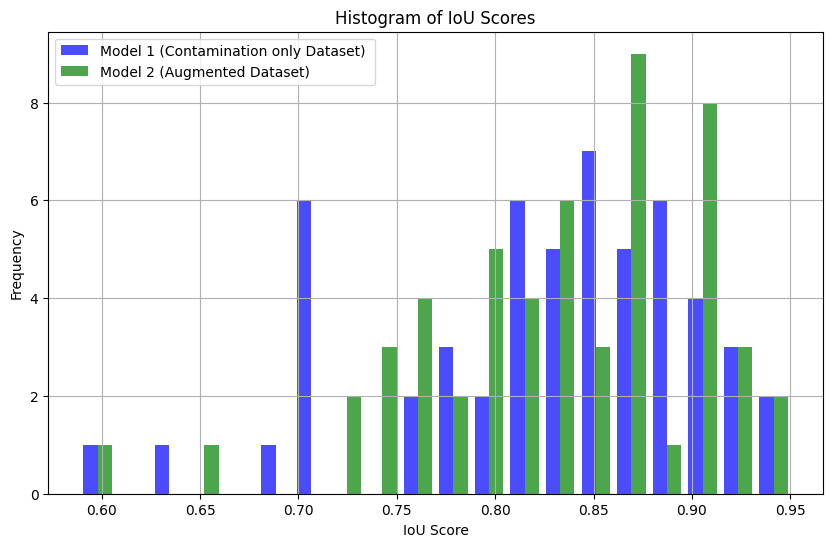

[0.8643398090220612, 0.7039636956675884, 0.7530056104728827, 0.8820703106417392, 0.784879876570421, 0.7724188520080689, 0.9361437241713209, 0.6881613756613757, 0.850823672971324, 0.8079100145137881, 0.8429079964113102, 0.8960178380754977, 0.898795355851518, 0.9026399364827312, 0.8502676497323503, 0.8052854364489189, 0.8821500583678235, 0.8860909975143196, 0.9306476098789203, 0.8313863986235625, 0.698522102193651, 0.8048314308468277, 0.8515513805863933, 0.8735801430374421, 0.8772906710991066, 0.8475284166005815, 0.6349856616140925, 0.8122019939315128, 0.8291131267321743, 0.8495242570186773, 0.8974266147766012, 0.7765429648739829, 0.9350959761476481, 0.8429570170895909, 0.828325382566136, 0.9188849034044427, 0.8783855954833295, 0.8081251192065612, 0.7070188774863804, 0.7120122519643095, 0.9226380265145159, 0.8994752186588921, 0.7108931947069943, 0.7099374519182526, 0.8380952380952381, 0.8729457585256958, 0.8095909732016925, 0.5928426738690075, 0.7543084002526391, 0.8689097260525832, 0.89

In [22]:

def plot_comparisons(images, titles, figsize=(20, 10), rows=1, cols=4):
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray' if i % 2 != 0 else None)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Load models
model1 = torch.load('./TrainingResults/WeightsContaminationOnly.pt')
model1.eval()

model2 = torch.load('./TrainingResults/weightsAugmented.pt')
model2.eval()

# Directory paths
image_dir =  os.path.join(parent_directory, "Data_Storage","Error_Measurements_Datasets","Uniq_Contamination_Only_Dataset")
mask_dir = os.path.join(parent_directory, "Data_Storage","Masks","Unique_Images_Masks",)

# Prepare to process and store results
processed_data = []

i = 800  # Number of images to process

# Process each image in the directory
for filename in os.listdir(image_dir):
    if i == 0:
        break
    i -= 1

    img_path = os.path.join(image_dir, filename)
    mask_path = os.path.join(mask_dir, filename)  # Ensure filenames match

    # Read the image and the corresponding mask
    img = cv2.imread(img_path)
    ground_truth_mask = cv2.imread(mask_path, 0)  # Load as grayscale

    # Resize and prepare image for model input
    resized_img = cv2.resize(img, (480, 320))
    img_for_model = resized_img.transpose(2, 0, 1).reshape(1, 3, 320, 480)
    img_tensor = torch.from_numpy(img_for_model).type(torch.cuda.FloatTensor) / 255

    # Model predictions
    with torch.no_grad():
        probability_map1 = model1(img_tensor)['out'].cpu().detach().numpy()[0][0]
        probability_map2 = model2(img_tensor)['out'].cpu().detach().numpy()[0][0]

    # Generate predicted masks
    predicted_mask1 = (probability_map1 > 0.4187).astype(np.uint8) * 255
    predicted_mask2 = (probability_map2 > 0.4187).astype(np.uint8) * 255

    resized_mask1 = cv2.resize(predicted_mask1, (img.shape[1], img.shape[0]))
    resized_mask2 = cv2.resize(predicted_mask2, (img.shape[1], img.shape[0]))

    # Calculate IoU for both models
    intersection1 = np.logical_and(ground_truth_mask, resized_mask1)
    union1 = np.logical_or(ground_truth_mask, resized_mask1)
    try :
        iou_score1 = np.sum(intersection1) / np.sum(union1) if np.sum(union1) != 0 else 0
    except:
        continue
    intersection2 = np.logical_and(ground_truth_mask, resized_mask2)
    union2 = np.logical_or(ground_truth_mask, resized_mask2)
    try:
        iou_score2 = np.sum(intersection2) / np.sum(union2) if np.sum(union2) != 0 else 0
    except:
        continue
    # Store results
    processed_data.append((filename, iou_score1, iou_score2, img, ground_truth_mask, resized_mask1, resized_mask2))

# Plot histogram of IoU scores
iou_scores1 = [data[1] for data in processed_data]
iou_scores2 = [data[2] for data in processed_data]

plt.figure(figsize=(10, 6))
plt.hist([iou_scores1, iou_scores2], bins=20, color=['blue', 'green'], alpha=0.7, label=['Model 1 (Contamination only Dataset) ', 'Model 2 (Augmented Dataset)'])
plt.title('Histogram of IoU Scores')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

print (iou_scores1)
print (iou_scores2)


Mean IoU for Model 1: 0.824
Mean IoU for Model 2: 0.832


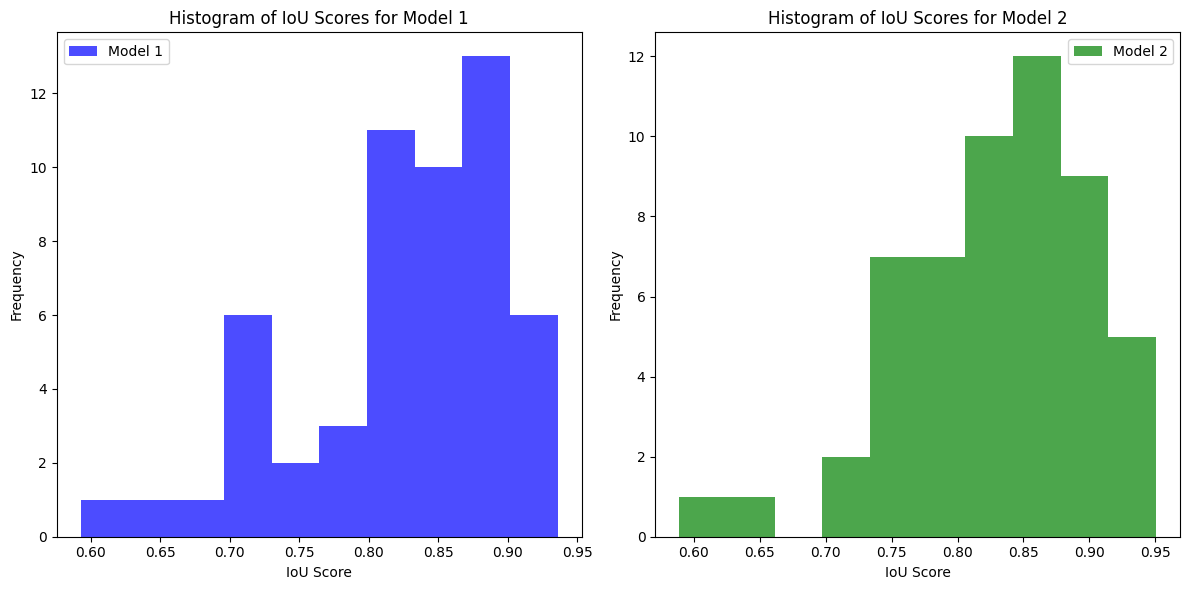

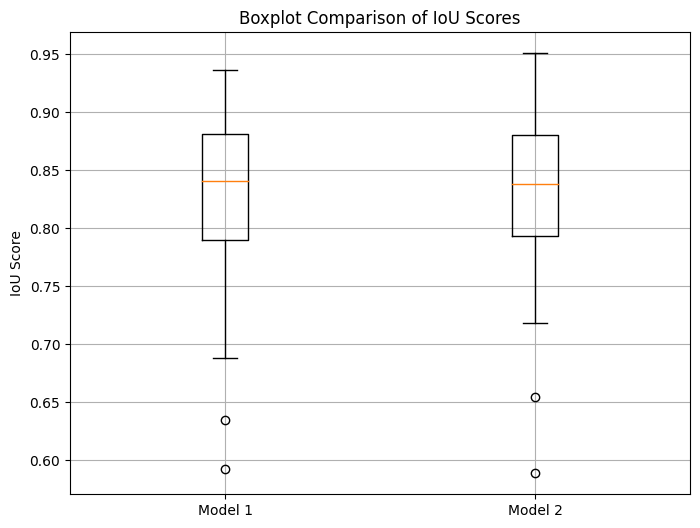

Standard Deviation for Model 1: 0.078
Standard Deviation for Model 2: 0.071


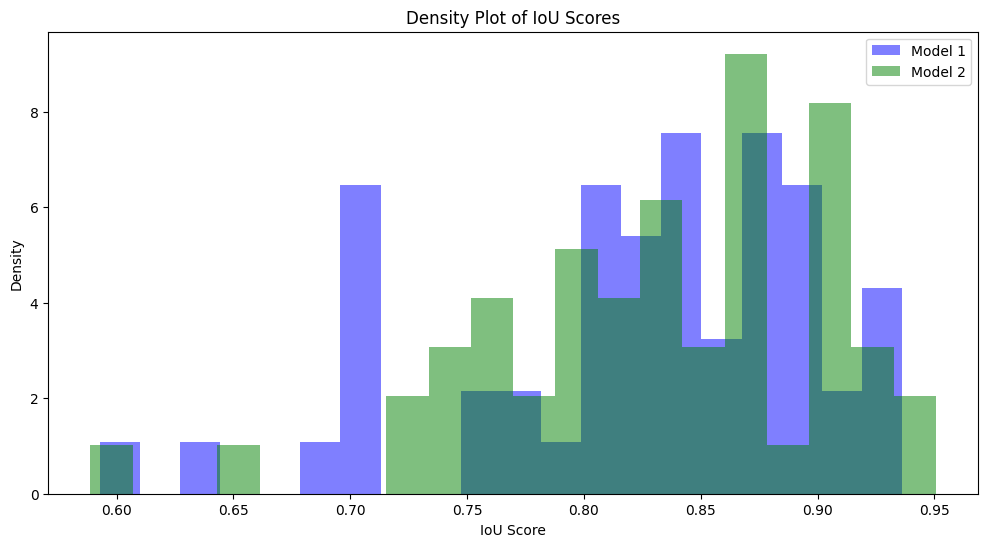

In [23]:
# Convert lists to numpy arrays for easier manipulation
iou_scores1 = np.array(iou_scores1)
iou_scores2 = np.array(iou_scores2)

# Calculate mean IoU for both models
mean_iou1 = np.mean(iou_scores1)
mean_iou2 = np.mean(iou_scores2)

print(f"Mean IoU for Model 1: {mean_iou1:.3f}")
print(f"Mean IoU for Model 2: {mean_iou2:.3f}")

# Plotting histograms of IoU scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(iou_scores1, bins=10, color='blue', alpha=0.7, label='Model 1')
plt.title('Histogram of IoU Scores for Model 1')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(iou_scores2, bins=10, color='green', alpha=0.7, label='Model 2')
plt.title('Histogram of IoU Scores for Model 2')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Boxplot to compare models
plt.figure(figsize=(8, 6))
plt.boxplot([iou_scores1, iou_scores2], labels=['Model 1', 'Model 2'])
plt.title('Boxplot Comparison of IoU Scores')
plt.ylabel('IoU Score')
plt.grid(True)
plt.show()

std_dev1 = np.std(iou_scores1)
std_dev2 = np.std(iou_scores2)

print(f"Standard Deviation for Model 1: {std_dev1:.3f}")
print(f"Standard Deviation for Model 2: {std_dev2:.3f}")

# Density Plot
plt.figure(figsize=(12, 6))
plt.hist(iou_scores1, bins=20, alpha=0.5, label='Model 1', color='blue', density=True)
plt.hist(iou_scores2, bins=20, alpha=0.5, label='Model 2', color='green', density=True)
plt.title('Density Plot of IoU Scores')
plt.xlabel('IoU Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [24]:

model = torch.load('./TrainingResults/weightsAugmented.pt')
model.eval()
Error_Measurements_Result = {'foldername': [],'succesed':0,'failed':0,'Zero_Contamination_Badly_Measured':0, 'mae top': [], 'mse top': [], 'rmse top': [], 'median top': [], 'mae bottom': [], 'mse bottom': [], 'rmse bottom': [], 'median bottom': [], 'mae height': [], 'mse height': [], 'rmse height': [], 'median height': []}
Error_Measurements_Results = []

def TestSpecificFolder(image_dir):
    processed_data = []

    for filename in os.listdir(image_dir):
        # Construct paths to the image
        img_path = os.path.join(image_dir, filename)

        # Read the image
        img = cv2.imread(img_path)

        # Resize the image to fit the model's expected input size and prepare it for the model
        resized_img = cv2.resize(img, (480, 320))
        img_for_model = resized_img.transpose(2, 0, 1).reshape(1, 3, 320, 480)
        img_tensor = torch.from_numpy(img_for_model).type(torch.cuda.FloatTensor) / 255

        # Apply the model to the image
        with torch.no_grad():
            a = model(img_tensor)

        # Get the probability map
        probability_map = a['out'].cpu().detach().numpy()[0][0]

        # Get the predicted mask
        predicted_mask = probability_map > 0.4124999999999999

        # Convert the mask to uint8
        predicted_mask_uint8 = predicted_mask.astype(np.uint8) * 255

        # Resize the mask to match the resized image
        resized_mask = cv2.resize(predicted_mask_uint8, (resized_img.shape[1], resized_img.shape[0]))

        # resize the mask to the original image size 1024x768
        mask = cv2.resize(resized_mask, (img.shape[1], img.shape[0]))


        top_height, bottom_height = measure_color_height(mask, color=255)  # Assuming yellow regions are represented by value 255

        if top_height is None or bottom_height is None:
            processed_data.append(ProcessedData(ImageName=filename, BottomHeightY=0, TopHeightY=0, ContaminationHeight=0))
            continue
        
        processed_data_instance = ProcessedData(ImageName=filename, BottomHeightY=int(bottom_height), TopHeightY=int(top_height), ContaminationHeight=int(bottom_height - top_height))
        processed_data.append(processed_data_instance)

    mae, mse, rmse, median, succesed, failed, Zero_Contamination_Badly_Measured = test_csv_data(processed_data)
    base_name = os.path.basename(image_dir)
    Error_Measurements_Result  = {'foldername': base_name,'succesed': succesed,'failed': failed,'Zero_Contamination_Badly_Measured':Zero_Contamination_Badly_Measured,'mae top': mae['top'], 'mse top': mse['top'], 'rmse top': rmse['top'], 'median top': median['top'], 'mae bottom': mae['bottom'], 'mse bottom': mse['bottom'], 'rmse bottom': rmse['bottom'], 'median bottom': median['bottom'], 'mae height': mae['height'], 'mse height': mse['height'], 'rmse height': rmse['height'], 'median height': median['height']}
    print(Error_Measurements_Result)
    Error_Measurements_Results.append(Error_Measurements_Result)

def TestErrorMeasurementAccrossAllDatasets(folder_paths):
    for folder_path in folder_paths:
        folder_path_name = os.path.basename(folder_path)
        print(f"Testing folder: {folder_path_name}")
        TestSpecificFolder(folder_path)
        print ("---------------------------------------------------------------------------")

    # store in the result error csv Error_Measurements_Results
    with open('Error_Measurements_Results.csv', mode='w') as file:
        writer = csv.DictWriter(file, fieldnames=Error_Measurements_Result.keys())
        writer.writeheader()
        for data in Error_Measurements_Results:
            writer.writerow(data)

if __name__ == "__main__":
    nano = False
    if nano:
        folder_path = os.path.join(parent_directory, "Data_Storage","Nano_Measurement_Datasets","Uniq_Images")
        TestSpecificFolder(folder_path)
    else:
        folder_path = os.path.join(parent_directory, "Data_Storage","Error_Measurements_Datasets")
        folder_paths = []
        for folder in os.listdir(folder_path):
            if folder == "Contamination_Only_Dataset" or folder == "Default_Dataset":
                continue

            folder_paths.append(os.path.join(folder_path, folder))

        TestErrorMeasurementAccrossAllDatasets(folder_paths)

    print("All processes have finished.")

Testing folder: Uniq_Contamination_Only_Dataset
Test results: 53 succesed, 1 failed, 0 zero contamination badly measured.
Number of Badly Valuated Non Contaminated images that are not zero:  0 out of  0
{'foldername': 'Uniq_Contamination_Only_Dataset', 'succesed': 53, 'failed': 1, 'Zero_Contamination_Badly_Measured': 0, 'mae top': 3.547169811320755, 'mse top': 21.92452830188679, 'rmse top': 4.6823635379887785, 'median top': 3.0, 'mae bottom': 3.660377358490566, 'mse bottom': 29.62264150943396, 'rmse bottom': 5.442668601838069, 'median bottom': 3.0, 'mae height': 5.509433962264151, 'mse height': 49.62264150943396, 'rmse height': 7.044334000417212, 'median height': 5.0}
---------------------------------------------------------------------------
Testing folder: Uniq_Dataset
Test results: 72 succesed, 1 failed, 19 zero contamination badly measured.
Number of Badly Valuated Non Contaminated images that are not zero:  19 out of  19
{'foldername': 'Uniq_Dataset', 'succesed': 72, 'failed': 1, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


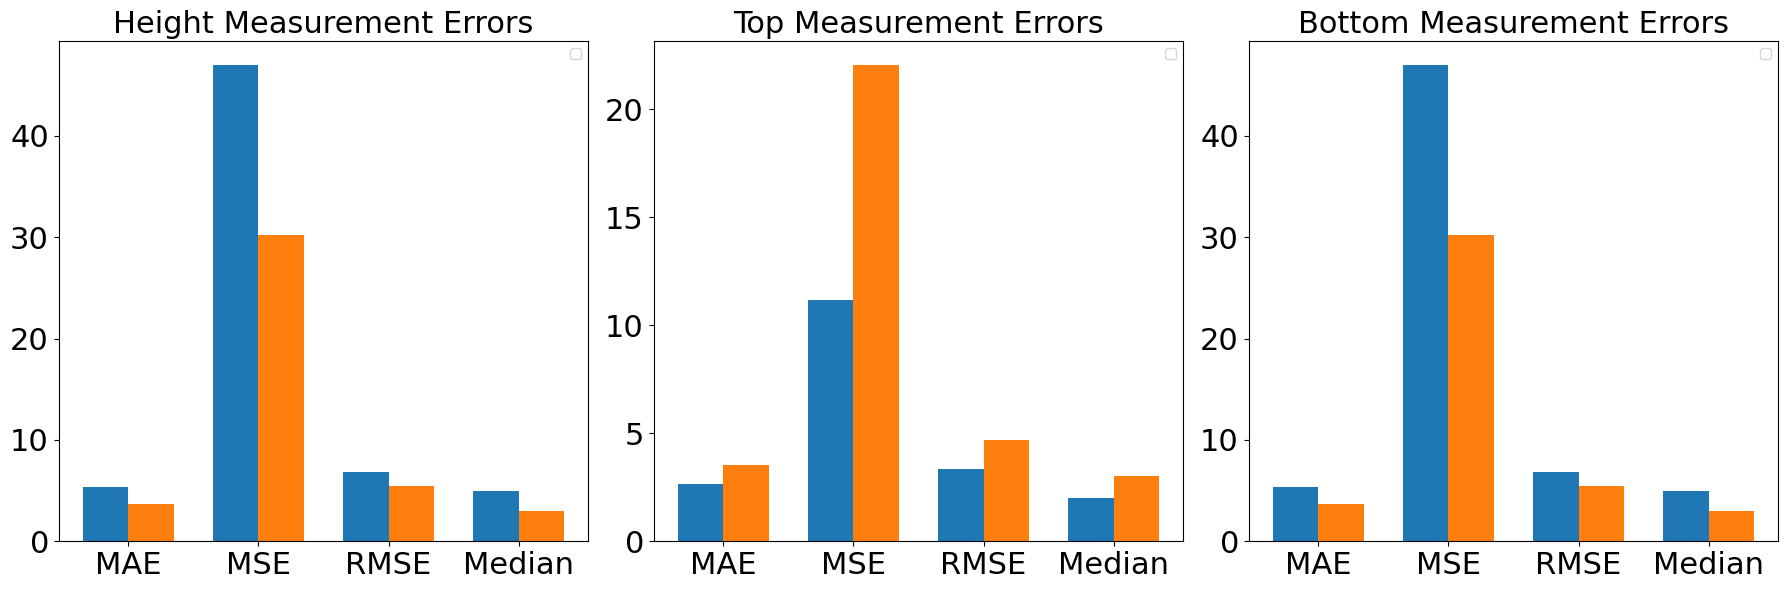

In [25]:
metrics = ['MAE', 'MSE', 'RMSE', 'Median']

# Updating the dictionaries for 'Image Processing' and 'Machine Learning' (Model) according to the new CSV values for Uniq_Dataset
height_errors = {
    'Image Processing': [5.33, 46.97, 6.85, 5.0], 
    'Machine Learning': [3.71, 30.17, 5.49, 3.0]  
}

top_errors = {
    'Image Processing': [2.67, 11.15, 3.34, 2.0],  
    'Machine Learning': [3.54, 22.04, 4.69, 3.0]   
}

bottom_errors = {
    'Image Processing': [5.33, 46.97, 6.85, 5.0],  
    'Machine Learning': [3.71, 30.17, 5.49, 3.0]  
}


# Function to create subplots for each type of measurement
def create_subplot(ax, data, title, fontsize=12): 
    index = np.arange(len(metrics))
    bar_width = 0.35

    ip = ax.bar(index, data['Image Processing'], bar_width)
    ml = ax.bar(index + bar_width, data['Machine Learning'], bar_width)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics, fontsize=fontsize) 
    ax.tick_params(axis='y', labelsize=fontsize) 
    ax.legend()

# Creating the plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6)) 

create_subplot(ax[0], height_errors, 'Height Measurement Errors', fontsize=22)
create_subplot(ax[1], top_errors, 'Top Measurement Errors', fontsize=22)
create_subplot(ax[2], bottom_errors, 'Bottom Measurement Errors', fontsize=22)

plt.tight_layout()
plt.show()


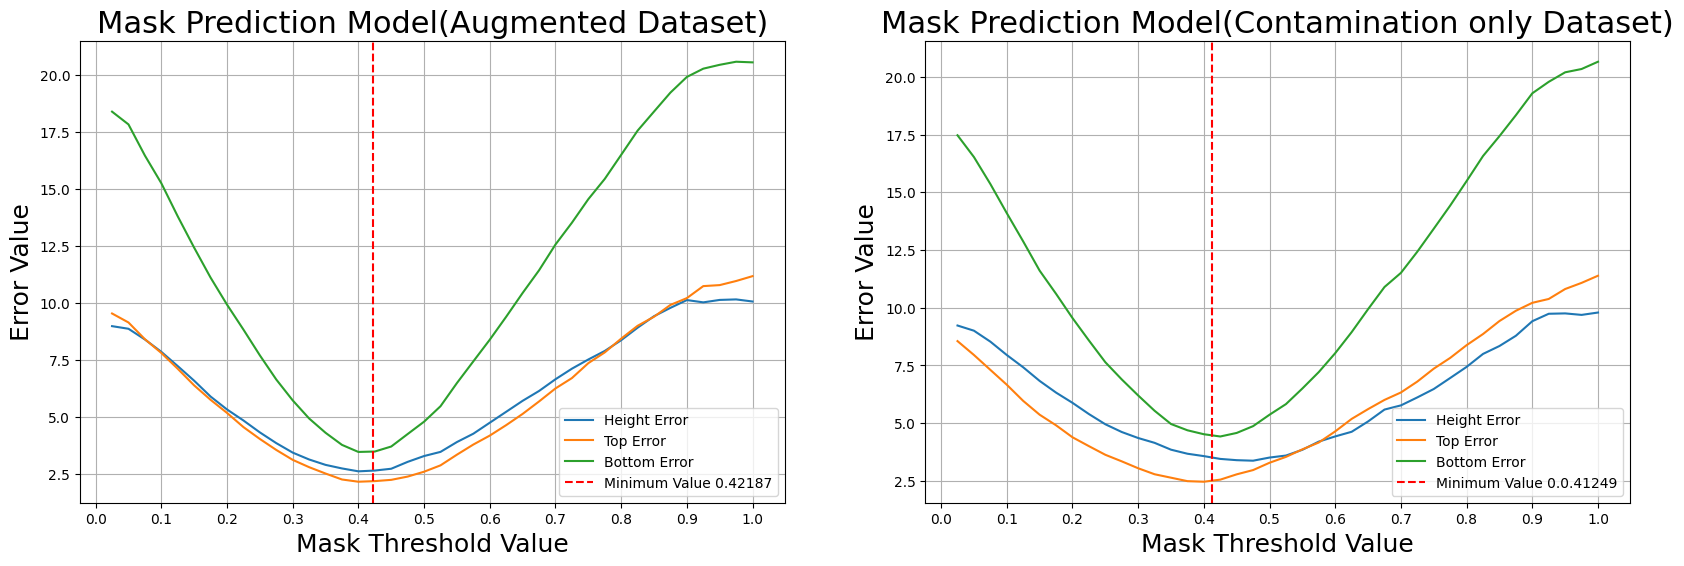

In [26]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to load data from CSV
def load_data(csv_file):
    data = []
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader, None)  # Skip header if present
        for row in reader:
            data.append(row)
    return data

# Function to extract and return data in a dictionary format
def extract_data(data):
    ERRORDICT = {'height': [], 'top': [], 'bottom': [], 'threshold': []}
    for row in data:
        ERRORDICT['height'].append(float(row[1]))
        ERRORDICT['top'].append(float(row[2]))
        ERRORDICT['bottom'].append(float(row[3]))
        ERRORDICT['threshold'].append(float(row[4]))
    return ERRORDICT

# Load data from both CSV files
csv_file = os.path.join(current_directory, "csvWeightsAugmented","error_measurements_0.0250.csv")
csv_file1 = os.path.join(current_directory, "csvWeightsContaminationOnly","error_measurements_0.0250.csv")

data = load_data(csv_file)
data1 = load_data(csv_file1)

ERRORDICT = extract_data(data)
ERRORDICT1 = extract_data(data1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plotting on the first subplot
ax1.plot(ERRORDICT['threshold'], ERRORDICT['height'], label='Height Error')
ax1.plot(ERRORDICT['threshold'], ERRORDICT['top'], label='Top Error')
ax1.plot(ERRORDICT['threshold'], ERRORDICT['bottom'], label='Bottom Error')
ax1.axvline(x=0.4218749999999999, color='r', linestyle='--', label='Minimum Value 0.42187')
ax1.set_xticks(np.arange(0.0, 1.1, step=0.1))
ax1.set_xlabel('Mask Threshold Value', fontsize=18)
ax1.set_ylabel('Error Value', fontsize=18)
ax1.set_title('Mask Prediction Model(Augmented Dataset)', fontsize=22)
ax1.legend()
ax1.grid(True)

# Plotting on the second subplot
ax2.plot(ERRORDICT1['threshold'], ERRORDICT1['height'], label='Height Error')
ax2.plot(ERRORDICT1['threshold'], ERRORDICT1['top'], label='Top Error')
ax2.plot(ERRORDICT1['threshold'], ERRORDICT1['bottom'], label='Bottom Error')
# Assuming you know the minimum value's threshold or calculate it similarly to the first
ax2.axvline(x=0.41249, color='r', linestyle='--', label='Minimum Value 0.0.41249')
ax2.set_xticks(np.arange(0.0, 1.1, step=0.1))
ax2.set_xlabel('Mask Threshold Value', fontsize=18)
ax2.set_ylabel('Error Value', fontsize=18)
ax2.set_title('Mask Prediction Model(Contamination only Dataset)', fontsize=22)
ax2.legend()
ax2.grid(True)

plt.show()
